# freecodecamp - Predict Health Costs with Linear Regression -


<div class="alert alert-block alert-info">
<b>freecodecamp:</b><br><br>In this challenge, you will predict healthcare costs using a regression algorithm.<br><br>You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.<br><br>The first two cells of this notebook import libraries and the data.<br><br>Make sure to convert categorical data to numbers. Use 80% of the data as the <code>train_dataset</code> and 20% of the data as the <code>test_dataset</code>.<br><br><code>pop</code> off the "expenses" column from these datasets to create new datasets called <code>train_labels</code> and <code>test_labels</code>. Use these labels when training your model.<br><br>Create a model and train it with the <code>train_dataset</code>. Run the final cell in this notebook to check your model. The final cell will use the unseen <code>test_dataset</code> to check how well the model generalizes.<br><br>To pass the challenge, <code>model.evaluate</code> must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.<br><br>The final cell will also predict expenses using the <code>test_dataset</code> and graph the results.
</div>

In [1]:
# Import libraries. You may or may not use all of these.
# !pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# try:
  # %tensorflow_version only exists in Colab.
  # %tensorflow_version 2.x
# except Exception:
  # pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

2023-12-18 10:15:52.744566: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-18 10:15:53.654434: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


>Download and load the dataset <code>insurance.csv</code> and show the last 5 rows of its content.

In [2]:
# Import data
# !wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


### Exploratory Data Analysis


The most important thing to start with is that we understand our data. There is no point in creating machine learning models if we don't understand what we are looking for in our data and what our expectations are. Therefore, we first check the data set for missing or duplicate values, column data types and get some basic information about the data.<br><br>We already know that our data set contains seven columns. According to the table, the data set should consist of four numerical and three categorical columns and can be checked with the following command:

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


It looks like there is no missing value (we can prove this with <code>dataset.isnull().sum()</code>) and all columns have the correct data type.<br>Next, we will analyse a simple summary statistics for all columns (categorical and numerical) of the data set. Finally, we will plot the distribution of the numerical values.

In [4]:
dataset.describe(include="all")

,age,sex,bmi,children,smoker,region,expenses
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.665471,1.094918,NaN,NaN,13270.422414
std,14.049960,NaN,6.098382,1.205493,NaN,NaN,12110.011240
min,18.000000,NaN,16.000000,0.000000,NaN,NaN,1121.870000
25%,27.000000,NaN,26.300000,0.000000,NaN,NaN,4740.287500
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.030000
75%,51.000000,NaN,34.700000,2.000000,NaN,NaN,16639.915000


The summary statistics give us an overview of the "mean", "standard deviation" and "quantiles" of $\left[0, 0.25, 0.5, 0.75, 1\right]$ (the latter reflecting the maximum and the former the minimum) for the numerical values. And for the categorical values, we get an overview of the individual categories, the most frequently mentioned category and the frequency of its occurrence.<br>In this way, we learn that:
- The average age in the data set is around 39 years.
- Gender is almost balanced, but men are slightly more represented than women.
- The average BMI is 30.6, which already counts as obese.
- The average person has about one child.
- Most people are non-smokers (more than three quarters).
- The list contains persons from four different regions, where about one quarter come from the southeast.
- And the average health costs are about 13270 units of one currency.

In [5]:
print("Column name ['sex']:", dataset["sex"].value_counts(), "\n")
print("Column name ['smoker']:", dataset["smoker"].value_counts(), "\n")
print("Column name ['region']:", dataset["region"].value_counts())

Column name ['sex']: sex
male      676
female    662
Name: count, dtype: int64 

Column name ['smoker']: smoker
no     1064
yes     274
Name: count, dtype: int64 

Column name ['region']: region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64


The challenge wants us to predict the health costs (<b>what would be medical costs for specific individual, based on other given information</b>) so our variable of interest should be “expenses”. Let us therefore first graphically illustrate how the other information influences healthcare costs, and finally also their correlation values.

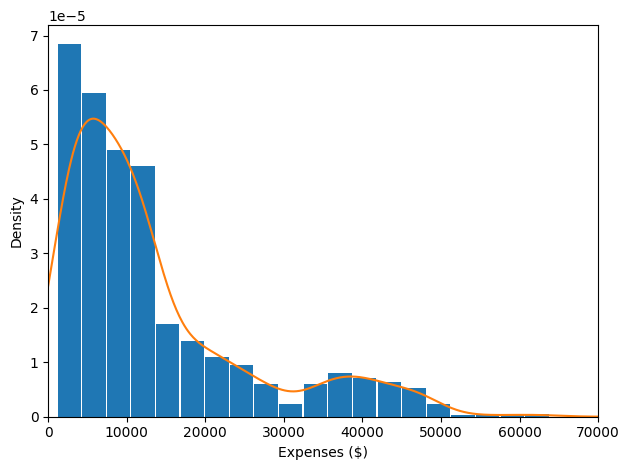

In [6]:
fig, ax=plt.subplots()
dataset["expenses"].hist(bins=20, rwidth=0.95, density=True, grid=False, ax=ax)
dataset["expenses"].plot.kde(ax=ax)
ax.set_xlabel("Expenses ($)")
ax.set_ylabel("Density")
ax.set_xlim(0, 70000)
plt.tight_layout()
plt.show()

The plot illustrates that the variable “expenses” do not follow a normal distribution. It is a uneven distribution and left biased. This could be a problem for the performances of our regression model later.

In [7]:
# let's create data series to highlight the influence of each categorical column within a visualisation
sex = dataset["sex"].replace({"male":200,
                              "female":100})
smoker = dataset["smoker"].replace({"yes":"tab:red",
                                    "no":"tab:blue"})
region = dataset["region"].replace({"southwest":"tab:blue",
                                    "southeast":"tab:red",
                                    "northwest":"tab:green",
                                    "northeast":"tab:purple"})
southnorth = dataset["region"].replace({"southwest":"tab:orange",
                                        "southeast":"tab:orange",
                                        "northwest":"tab:green",
                                        "northeast":"tab:green"})
eastwest = dataset["region"].replace({"southwest":"tab:olive",
                                      "southeast":"tab:purple",
                                      "northwest":"tab:olive",
                                      "northeast":"tab:purple"})

In [8]:
def pairplot(df, size, color):
    """Function to plot a pairplot of the numerical values of a dataframe,
    where the markersize and the color are used to highlight specific categories.

    Parameters
    ----------
    df : 2d array
        of a pandas DataFrame, of preferably numerical data
    size : 1d array
        containing integers for different markersizes
    color : 1d array
        containing color strings for different categories
    
    Returns
    -------
    fig : figure
        a pandas scatter_matrix of each numerical column
        with the possibility of highlighting two different
        categorical columns
    """
    fig, ax=plt.subplots(figsize=(8,8))
    pd.plotting.scatter_matrix(df, s=size, c=color,
                               hist_kwds={"rwidth" : 0.9}, #diagonal="kde", 
                               alpha=0.2, ax=ax)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_44437/705742879.py:22: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.plotting.scatter_matrix(df, s=size, c=color,


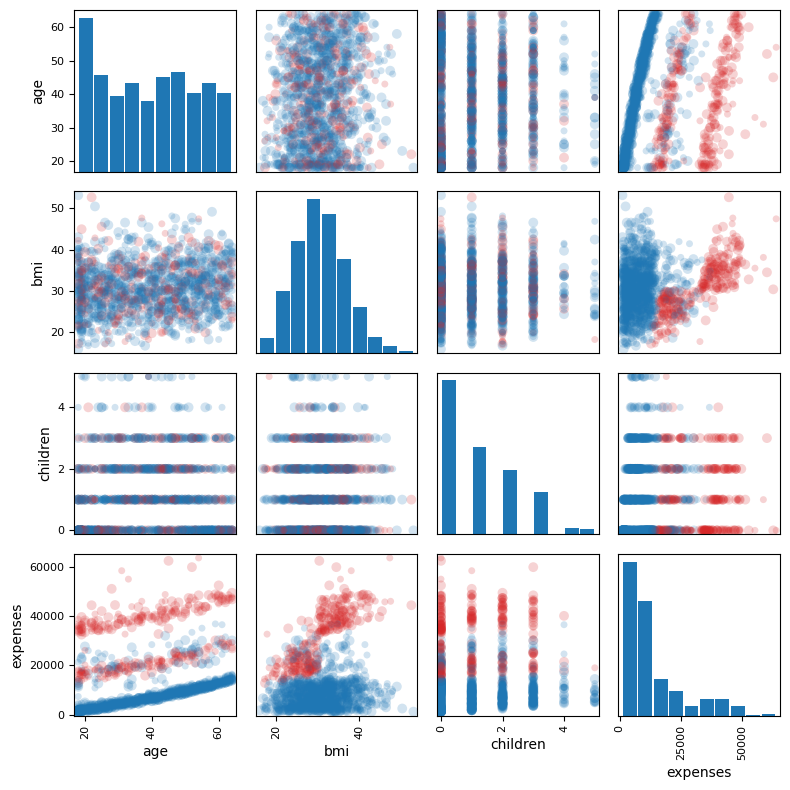

In [9]:
pairplot(df=dataset[["age", "bmi", "children", "expenses"]], size=sex, color=smoker)

Together with the information we have obtained in the summary statistics, we can see that the data (bmi) is well distributed, apart from smokers. Yes, we can also see that there are a few more younger people on the list than older people, but they are not significantly overrepresented. We should also consider that this data should represent the society in that area, which could be the reason for the age and child distribution. At best, we would also need to check our data against the population data from these areas to see if all categories are sufficiently represented. If necessary, we would have to make a few adjustments.<br>Smokers are underrepresented by a quarter, but we can already assume, based on the data we see from this representation, that they have quite a large impact on healthcare costs. On the one hand, it look like that expenditure increases with age, but if we compare smokers with non-smokers, we can see that non-smokers have lower healthcare costs than smokers. It also seems to be that younger smoker have higher healthcare costs than older non-smokers. Furthermore, the BMI suggests that smokers with a BMI over 30 have the highest expenditure.

In [10]:
correlation_matrix = dataset[["age", "bmi", "children", "expenses"]].corr()
#correlation_matrix.style.background_gradient(cmap='coolwarm').set_precision(4)
correlation_matrix.round(2)

,age,bmi,children,expenses
age,1.00,0.11,0.04,0.30
bmi,0.11,1.00,0.01,0.20
children,0.04,0.01,1.00,0.07
expenses,0.30,0.20,0.07,1.00


Using the correlation matrix, we can see that there is a tendency between age, BMI and expenses, but we can not say it's strong.<br>But we can definitely say that the number of children covered by health insurance has the lowest correlation with expenses, meaning that having more or fewer children has no impact on your medical costs. You might not have expected that now!

### Regression algorithm

After getting a insight into our data, we can already say that we want to predict the "expanses" column based on the other costumers information.

https://www.tensorflow.org/tutorials/keras/regression

https://www.geeksforgeeks.org/linear-regression-using-tensorflow/

Before we can build our model, we need to convert the categorical features into numerical values to improve our machine learning algorithm by simplifying its input for further processing. By using the availabe packages, we convert our categorical data into numerical data with the <b>Dummy Variable Encoding</b> method.

<div class="alert alert-block alert-info">
<b>Note:</b> You can set up the tf.keras.Model to do this kind of transformation for you, see the following <a href="https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers">tensorflow tutorial</a>.
</div>

In [11]:
# get the dummies and store it in a variable
dummies_sex = pd.get_dummies(dataset["sex"], drop_first=True, dtype=int)  # alternative: pd.factorize(dataset["sex"])[0]
dummies_smoker = pd.get_dummies(dataset["smoker"], drop_first=True, dtype=int)  # alternative: pd.factorize(dataset["smoker"])[0]
#  to make the final array more compact
dummies_region = pd.factorize(dataset["region"])[0]  # alternative: pd.get_dummies(dataset["region"], drop_first=True, dtype=int)

In [12]:
dummies_sex.head().T

,0,1,2,3,4
male,0,1,1,1,1


In [13]:
dummies_smoker.head().T

,0,1,2,3,4
yes,1,0,0,0,0


In [14]:
print(np.unique(dummies_region))
dummies_region[:5].T

[0 1 2 3]


array([0, 1, 1, 2, 2])

We have to be carefull in the case of <code>dummies_region</code>. This variable is a <code>numpy array</code> and must be added individually to the merged data frame.

In [15]:
# Concatenate the dummies to original dataframe
merged = pd.concat([dataset[["age", "bmi", "children", "expenses"]], dummies_sex, dummies_smoker], axis='columns')
merged.rename(columns={"male" : "sex",
                       "yes" : "smoker"}, inplace=True)
merged["region"] = dummies_region
merged.head()

,age,bmi,children,expenses,sex,smoker,region
0,19,27.9,0,16884.92,0,1,0
1,18,33.8,1,1725.55,1,0,1
2,28,33.0,3,4449.46,1,0,1
3,33,22.7,0,21984.47,1,0,2
4,32,28.9,0,3866.86,1,0,2


We can now split our data frame after converting the categorical data into numeric data by using <a href="https://www.geeksforgeeks.org/ml-one-hot-encoding-of-datasets-in-python/"><b>One Hot Encoding</b></a>. As requested in the task, we use 80% of the newly created data frame for our training split and 20% for our test split.

In [16]:
train_dataset = merged.sample(frac=0.8, random_state=318)
test_dataset = merged.drop(train_dataset.index)

/tmp/ipykernel_44437/705742879.py:22: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.plotting.scatter_matrix(df, s=size, c=color,


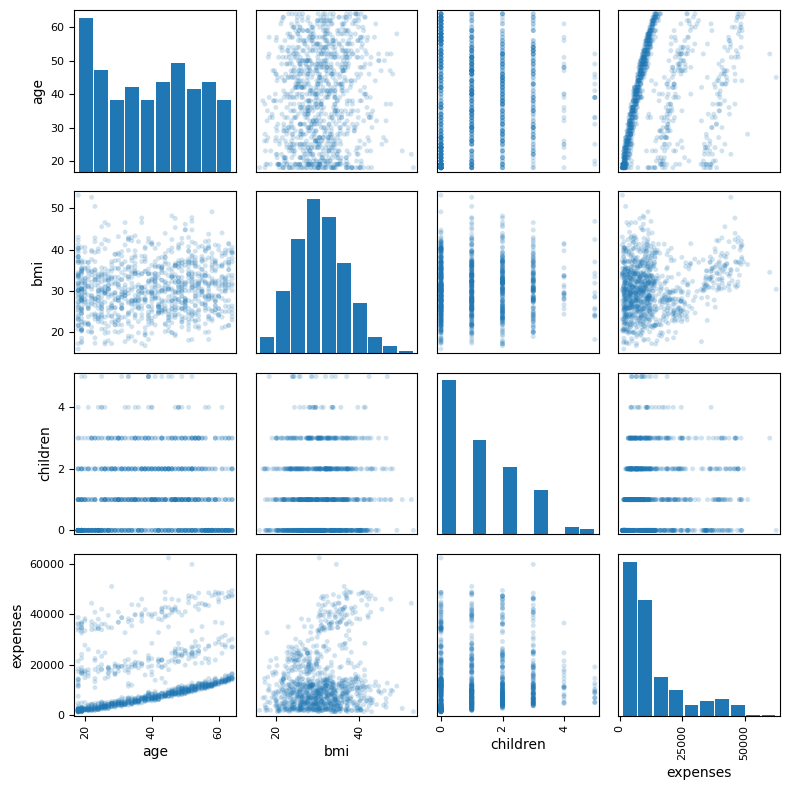

In [17]:
pairplot(df=train_dataset[["age", "bmi", "children", "expenses"]], size=50, color="tab:blue")

In [18]:
def df_normalize(df, method="min-max"):
    """Function to normalize each column
    of a pandas dataframe

    Parameters
    ----------
    df : 2d array
        of a pandas dataframe, containing numerical data
    method : str
        describe the kind of the normalization
        "min-max": (x - min[x]) / (max[x] - min[x])
        "mean": (x - mean[x]) / std[x]
        default: "min-max"

    Returns
    -------
    normed : 2d array
        of a pandas dataframe, contains normalized
        numerical data based on the choosen method
    """
    if method == "min-max":
        df_normed = (df - df.min()) / (df.max() - df.min())
#        df_normed = df.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
    elif method == "mean":
        df_normed = (df - df.mean()) / df.std()
#        df_normed = df.apply(lambda x: (x-x.mean())/ x.std(), axis=0)
    else:
        print("Choose a method!")
    
    return df_normed

In [19]:
def compare_stats(origin, compare, columns, normalized=True):
    """Function to compare the "mean", "std" and "quantiles" of a origin and a reduced/second
    dataset.

    Parameters
    ----------
    origin : 2d array
        of a pandas dataframe, containing numerical data
    compare : 2d array
        of a pandas dataframe, containing numerical data
        as a reduced dataframe of the origin or completly
        different data to compare with
    columns : list
        of the dataframe columns to compare
        note: columns should be include in both dataframes!
    normalized : bool
        if True the dataframes get normalized after min-max
        normalization, else real values
        default: True

    Returns
    -------
    fig : figure
        a pandas bar plot which compares the origin
        with the reduced/second dataset
    """
    try:
        set(origin.columns).issuperset(set(columns))
    except:
        print("The selected columns are not represented in the origin dataframe")
    
    try:
        set(compare.columns).issuperset(set(columns))
    except:
        print("The selected columns are not represented in the reduced dataframe")
    
    fig, ax=plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(8,8))
    if normalized:
        origin = df_normalize(origin)
        compare = df_normalize(compare)
        ax[0,0].set_ylabel("Normalized value (-)")
        ax[1,0].set_ylabel("Normalized value (-)")

    def subplot(row):
        return pd.DataFrame({'origin': origin[columns].describe().loc[row],
                            'compare': compare[columns].describe().loc[row]
                            }, index=columns)

    subplot("mean").plot.bar(alpha=0.75, grid=False, ax=ax[0,0])
    ax[0,0].set_title("Mean")
    subplot("std").plot.bar(alpha=0.75, grid=False, ax=ax[1,0])
    ax[1,0].set_title("Standard deviation")
    subplot("25%").plot.bar(alpha=0.75, grid=False, ax=ax[0,1])
    ax[0,1].set_title("25% Quantile")
    subplot("75%").plot.bar(alpha=0.75, grid=False, ax=ax[1,1])
    ax[1,1].set_title("75% Quantile")
    plt.tight_layout()
    plt.show()
    

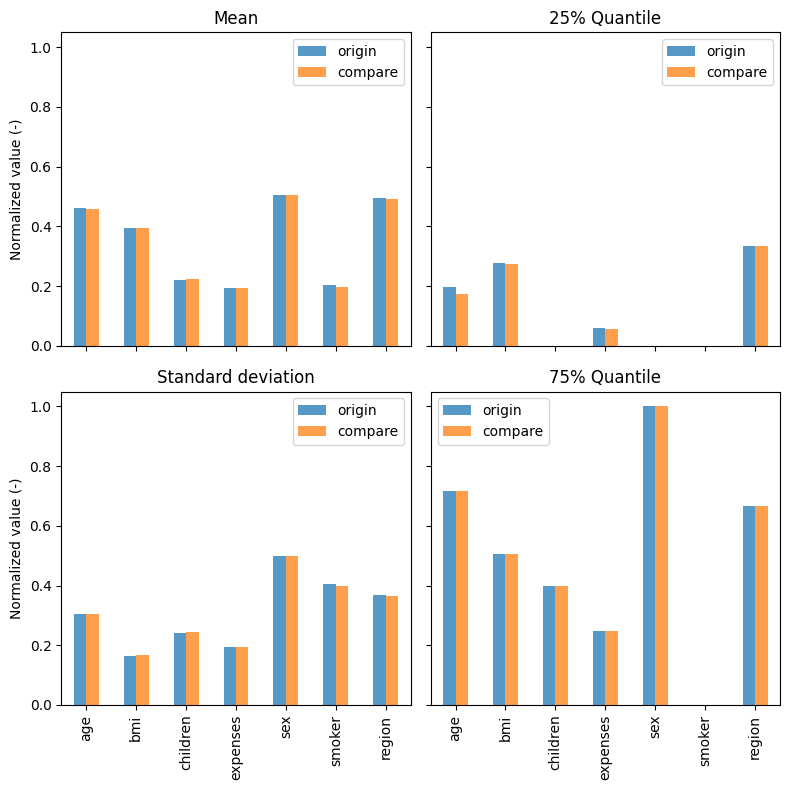

In [20]:
compare_stats(origin=merged, compare=train_dataset, columns=merged.columns) #["age", "bmi", "children", "expenses"])

When we compare the training dataset with the original dataset, we see a good representation of its original distribution within the training set. This means that we neither over- nor under-represent certain data. Together with <code>random_state</code> we make both the training and the test dataset repeatable, otherwise we would get different results each time, probably not significant, but different.<br><br>Now we will split features and labels from the datasets. This means we separate the target value ("label") from the features. The label is the value that you will train the model to predict.

In [21]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop("expenses")
test_labels = test_features.pop("expenses")

We add now feature normailzation to our model, after splitting our data sets into features and layer. The aim of normalization is to convert all features to a similar (same) scale. This improves the performance and training stability of the model (faster convergence on learning, and more uniform influence for all weights).

In [22]:
# Create the normalizer layer
normalizer = layers.Normalization()  # normalizer = tf.keras.layers.Normalization(axis=-1)
# Then, fit the state of the preprocessing layer to the data by calling
normalizer.adapt(np.array(train_features))
# Calculate the mean and variance, and store them in the layer:
print(normalizer.mean.numpy())
# When the layer is called, it returns the input data, with each feature independently normalized:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

2023-12-18 10:16:03.429457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 10:16:03.459596: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 10:16:03.459844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[[39.135513   30.650377    1.1242992   0.5056075   0.19626169  1.47757   ]]
First example: [[59.  27.5  0.   0.   0.   0. ]]

Normalized: [[ 1.42 -0.51 -0.93 -1.01 -0.49 -1.35]]


#### Linear regression

Before building a deep neural network model, start with linear regression using multiple inputs. The model will apply a linear transformation $y = mx+b$ where $m$ is a matrix for the slope and $x$ is a vector.<br>To build the model, create a two-step Keras Sequential model again with the first layer being normalizer (tf.keras.layers.Normalization(axis=-1)) you defined earlier.<br>More than 2 layers are usually not necessary, and in the following we will also check which combination of neurons makes sense in each hidden layer.<br>A good rule of thumb to prevent over-fitting is to keep your number of neurons below:

$\text{\# of neurons}_{hidden layer} = \frac{\text{\# of sample}}{\alpha\left(\text{\# of neurons}_{input layer} + \text{\# of neurons}_{output layer}\right)}$

where $\alpha$ stands for an arbitrary scaling factor, usually between 2 and 10.

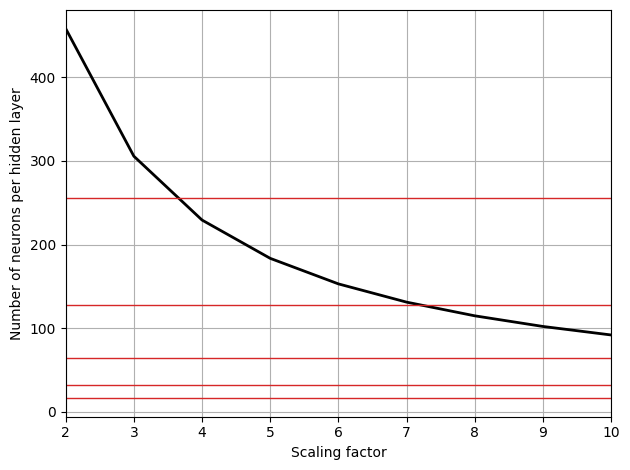

In [23]:
alpha = np.linspace(2, 10, num=9, endpoint=True)
n_samples = train_features.shape[0] * train_features.shape[1]
n_input = train_features.shape[1]
n_output = 1
n_hl = n_samples / (alpha * (n_input + n_output))
fig, ax=plt.subplots()
ax.plot(alpha, n_hl, color="black", linewidth=2)
for neuron in [16, 32, 64, 128, 256]:
    ax.hlines(neuron, 2, 10, color="tab:red", linewidth=1)
ax.grid(True)
ax.set_xlabel("Scaling factor")
ax.set_ylabel("Number of neurons per hidden layer")
ax.set_xlim(2, 10)
plt.tight_layout()
plt.show()

According to this rule of thumb and the graph, we should have between 64 and 128 neurons to achieve good results in a reasonable time. We will check this in a small loop.

In [24]:
import random

def dnn_model(n_1, n_2):
    """Function for our Deep Neural Network Model set up.

    Parameters
    ----------
    n_1 : int
        number of neurons within the first hidden layer
    n_2 : int
        number of neurons within the first hidden layer
    
    Returns
    -------
    model
    """
    random.seed(318)
    model = keras.Sequential([normalizer,
                              layers.Dense(n_1, activation="relu"),
                              layers.Dense(n_2, activation="relu"),
                              layers.Dense(1)])
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss="mean_absolute_error",
                  metrics=["mae", "mse"])
    return model

In [25]:
neurons = [32, 64, 128, 256]  # see graph before
combinations = np.stack(np.meshgrid(neurons, neurons), -1).reshape(-1,2)
print(combinations.shape)

(16, 2)


In [26]:
results = {}
for i in combinations:
    model = dnn_model(n_1=i[0], n_2=i[1])
    model_history = model.fit(train_features,
                              train_labels,
                              validation_split=0.2,
                              verbose=0,
                              epochs=100)    
    results[str(i[0]) + ", " + str(i[1])] = {"loss" : model_history.history["loss"],
                                             "val_loss" : model_history.history["val_loss"],
                                             "epoch" : model_history.epoch}
    progress = (np.where((combinations[:, 0] == i[0]) & (combinations[:, 1] == i[1]))[0] + 1) / combinations.shape[0] * 100
    print("Progress:", progress)

2023-12-18 10:16:05.020371: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55b765cc7ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-18 10:16:05.020401: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 850M, Compute Capability 5.0
2023-12-18 10:16:05.027328: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-18 10:16:05.120456: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-12-18 10:16:05.325590: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Progress: [6.25]
Progress: [12.5]
Progress: [18.75]
Progress: [25.]
Progress: [31.25]
Progress: [37.5]
Progress: [43.75]
Progress: [50.]
Progress: [56.25]
Progress: [62.5]
Progress: [68.75]
Progress: [75.]
Progress: [81.25]
Progress: [87.5]
Progress: [93.75]
Progress: [100.]


In [27]:
rkeys = [str(f) + ", " + str(s) for f, s in combinations]

In [28]:
def plot_loss(loss, validation_loss, epoch, title, ax=None, legend=True):
    ax = ax
    ax.plot(epoch, loss, color="tab:blue", label="loss")
    ax.plot(epoch, validation_loss, color="tab:orange", label="val_loss")
    ax.set_xlim([0, len(epoch)])
    ax.set_ylim([0, 15000])
    #plt.xlabel("Epoch")
    #plt.ylabel("Error (expenses)")
    ax.set_title(title)
    #plt.legend()
    #plt.tight_layout()
    #plt.grid(True)
    #plt.show()

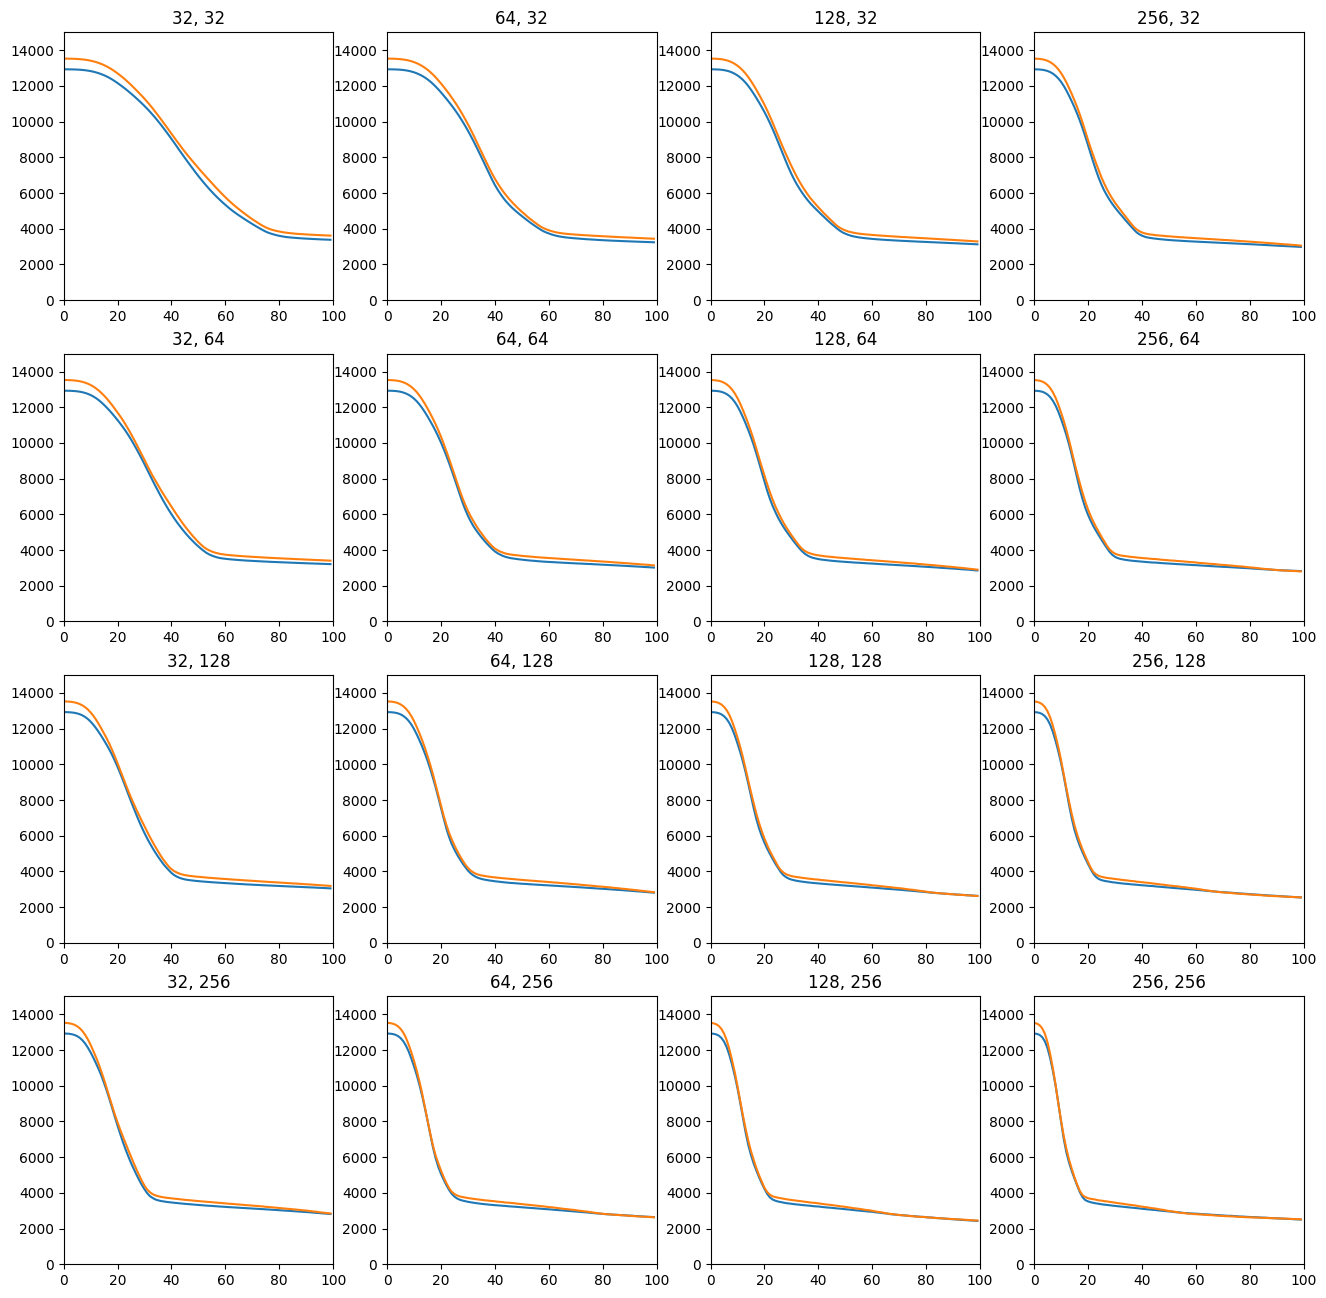

In [29]:
fig, ax =plt.subplots(nrows=len(neurons), ncols=len(neurons), figsize=(16, 16))
k = 0
for i in range(len(neurons)):
    for j in range(len(neurons)):
        plot_loss(results[rkeys[k]]["loss"],
                results[rkeys[k]]["val_loss"],
                results[rkeys[k]]["epoch"],
                title=rkeys[k],  # "# neurons in 1, 2 layer: " + rkeys[k],
                ax=ax[i, j])
        k += 1

We can see that all models fit quite well. So there is no over- or under-fitting. Let us now check whether all models are within the "<b>MAE</b>" of 3500 required by fcc.

In [30]:
k = 0
loss_mat = np.zeros((len(neurons), len(neurons)))
valloss_mat = np.zeros((len(neurons), len(neurons)))
for i in range(len(neurons)):
    for j in range(len(neurons)):
        loss_mat[i, j] = results[rkeys[k]]["loss"][-1]
        valloss_mat[i, j] = results[rkeys[k]]["val_loss"][-1]
        k += 1

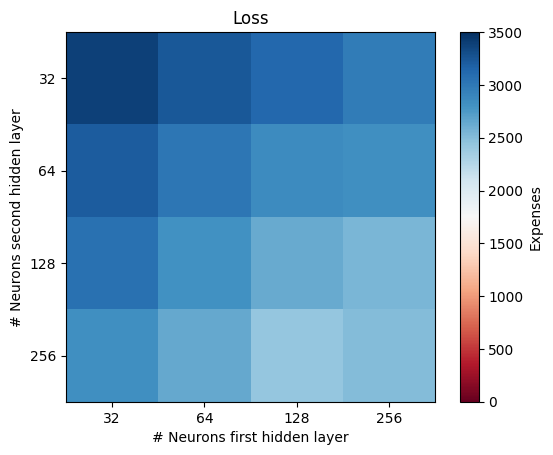

In [31]:
fig, ax=plt.subplots()
c = ax.imshow(loss_mat, cmap='RdBu',  vmin=0, vmax=3500)
ax.set_xlabel("# Neurons first hidden layer")
ax.set_xticks(range(len(neurons)))
ax.set_xticklabels(neurons)
ax.set_ylabel("# Neurons second hidden layer")
ax.set_yticks(range(len(neurons)))
ax.set_yticklabels(neurons)
plt.title("Loss")
#plt.title()
cbar = fig.colorbar(c, ax=ax)
cbar.set_label("Expenses")

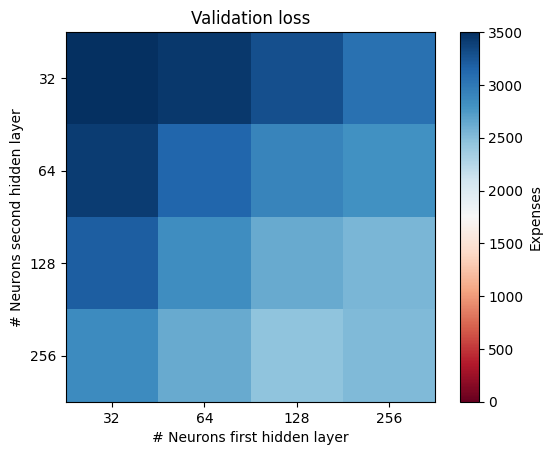

In [32]:
fig, ax=plt.subplots()
c = ax.imshow(valloss_mat, cmap='RdBu',  vmin=0, vmax=3500)
ax.set_xlabel("# Neurons first hidden layer")
ax.set_xticks(range(len(neurons)))
ax.set_xticklabels(neurons)
ax.set_ylabel("# Neurons second hidden layer")
ax.set_yticks(range(len(neurons)))
ax.set_yticklabels(neurons)
plt.title("Validation loss")
#plt.title()
cbar = fig.colorbar(c, ax=ax)
cbar.set_label("Expenses")

The validation loss of the model with 32 neurons is slightly higher in both hidden layers than the max "MAE" required by fcc. All others perform well.<br>Furthermore, we also require that the difference between training and validation loss is as small as possible.

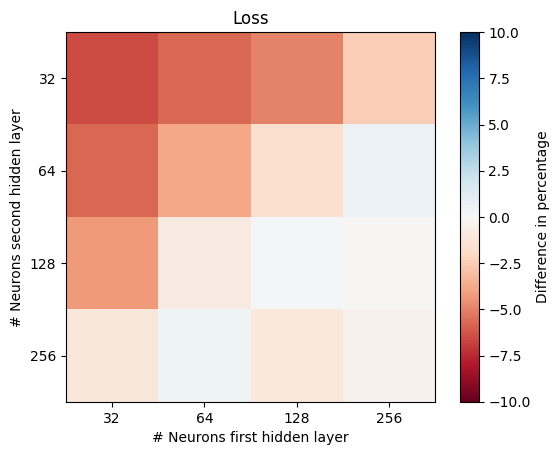

In [33]:
fig, ax=plt.subplots()
c = ax.imshow((loss_mat/valloss_mat - 1)*100, cmap='RdBu',  vmin=-10, vmax=10)
ax.set_xlabel("# Neurons first hidden layer")
ax.set_xticks(range(len(neurons)))
ax.set_xticklabels(neurons)
ax.set_ylabel("# Neurons second hidden layer")
ax.set_yticks(range(len(neurons)))
ax.set_yticklabels(neurons)
plt.title("Loss")
#plt.title()
cbar = fig.colorbar(c, ax=ax)
cbar.set_label("Difference in percentage")

The difference is quite small in all models. The choice therefore fell on 128 neurons in both layers!

In [34]:
model = keras.Sequential([normalizer,
                          layers.Dense(128, activation="relu"),
                          layers.Dense(128, activation="relu"),
                          layers.Dense(1)])
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss="mean_absolute_error",
              metrics=["mae", "mse"])
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 6)                 13        


 on)                                                             
                                                                 
 dense_48 (Dense)            (None, 128)               896       
                                                                 
 dense_49 (Dense)            (None, 128)               16512     
                                                                 
 dense_50 (Dense)            (None, 1)                 129       
                                                                 
Total params: 17550 (68.56 KB)
Trainable params: 17537 (68.50 KB)
Non-trainable params: 13 (56.00 Byte)
_________________________________________________________________


Train the model!

In [35]:
%%time
model_history = model.fit(train_features,
                          train_labels,
                          validation_split=0.2,
                          verbose=0,
                          epochs=100)

CPU times: user 19.1 s, sys: 995 ms, total: 20.1 s
Wall time: 17.5 s


This model will predict "expenses" from training features.

Visualize the model's training progress using the stats stored in the history object:

In [36]:
df_model_history = pd.DataFrame(model_history.history)
df_model_history["epoch"] = model_history.epoch
df_model_history.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,2652.590576,2652.590576,35331396.0,2650.491455,2650.491455,34655300.0,95
96,2639.959961,2639.959961,34944300.0,2637.830322,2637.830322,34407768.0,96
97,2629.410645,2629.410645,34865012.0,2632.200684,2632.200684,34283040.0,97
98,2620.854492,2620.854492,34593092.0,2618.398926,2618.398926,33998660.0,98
99,2606.493164,2606.493164,34291856.0,2611.614746,2611.614746,33688228.0,99


In [37]:
def plot_loss_history(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlim([0, len(history.epoch)])
    plt.xlabel("Epoch")
    plt.ylabel("Error (expenses)")
    plt.legend()
    plt.grid(True)
    plt.show()

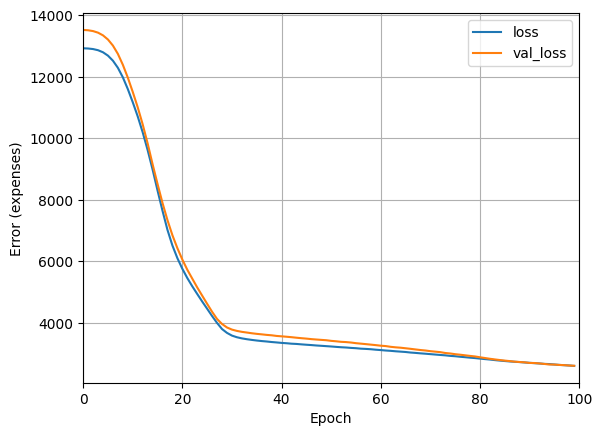

In [38]:
plot_loss_history(model_history)

In [39]:
test_loss, test_mae, test_mse  = model.evaluate(test_features, test_labels, verbose=0)

In [40]:
print("loss:", test_loss)
print("mean absolute error:", test_mae)
print("mean squared error:", test_mse)

loss: 2848.50048828125
mean absolute error: 2848.50048828125
mean squared error: 38614052.0


#### Make predictions

You can now make predictions with the dnn_model on the test set using Keras Model.predict and review the loss:

9/9 [==============================] - 0s 2ms/step


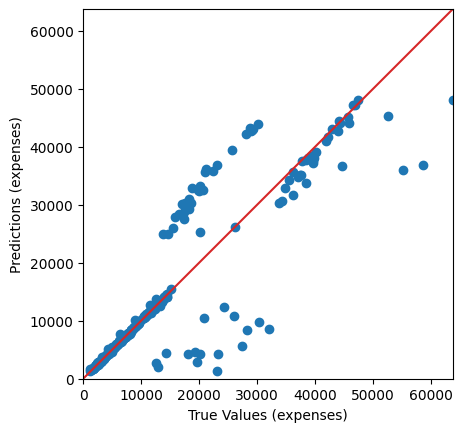

In [41]:
test_predictions = model.predict(test_features).flatten()

a = plt.axes(aspect="equal")
plt.scatter(test_labels, test_predictions)
plt.xlabel("True Values (expenses)")
plt.ylabel("Predictions (expenses)")
lims = [0, test_labels.max()]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, color="tab:red")

It appears that the model predicts reasonably well.

Now, check the error distribution:

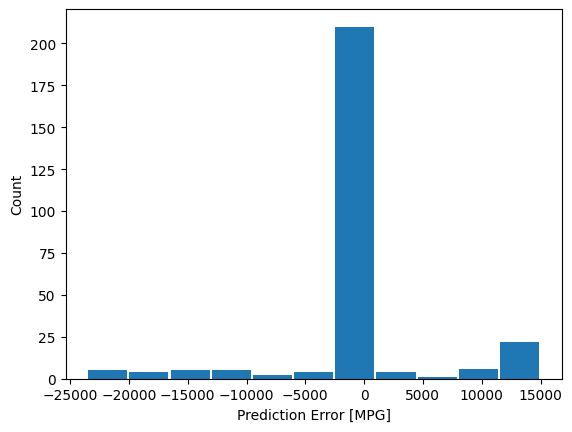

In [42]:
error = test_predictions - test_labels
plt.hist(error, bins=11, rwidth=0.95)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [43]:
test_dataset = test_features  # has to be changed to fit freecodecamp TEST

9/9 - 0s - loss: 2848.5005 - mae: 2848.5005 - mse: 38614052.0000 - 58ms/epoch - 6ms/step


Testing set Mean Abs Error: 2848.50 expenses
You passed the challenge. Great job!
9/9 [==============================] - 0s 3ms/step


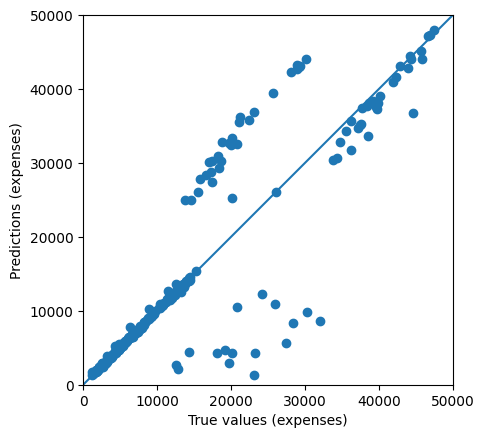

In [44]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
